<div style="width:1000 px">

<div style="float:right; width:98 px; height:98px;"><img src="https://pbs.twimg.com/profile_images/1187259618/unidata_logo_rgb_sm_400x400.png" alt="Unidata Logo" style="height: 98px;"></div>

<h1>Working with Surface Observations in Siphon and MetPy</h1>
<h3>Unidata Python Workshop</h3>

<div style="clear:both"></div>
</div>

<hr style="height:2px;">

<div style="float:right; width:250 px"><img src="http://weather-geek.net/images/metar_what.png" alt="METAR" style="height: 200px;"></div>

## Overview:

* **Teaching:** 50 minutes
* **Exercises:** 40 minutes

### Questions
1. What is a THREDDS Data Server?
1. How can I download surface data?
1. How do you make map-based plots in Python?
1. How can I plot surface data?

### Objectives
1. Use CartoPy to make georeferenced plots on top of matplotlib
1. Use Siphon to access and download surface data from a THREDDS data server
1. Plot the surface data using a MetPy Station Plot

## What is THREDDS?

 * Server for providing remote access to datasets
 * Variety of services for accesing data:
   - HTTP Download
   - Web Mapping/Coverage Service (WMS/WCS)
   - OPeNDAP
   - NetCDF Subset Service
   - CDMRemote
 * Provides a more uniform way to access different types/formats of data
 * METAR Collectin: http://thredds.ucar.edu/thredds/catalog/nws/metar/ncdecoded/catalog.html?dataset=nws/metar/ncdecoded/Metar_Station_Data_fc.cdmr

### THREDDS Catalogs
- XML descriptions of data and metadata
- Access methods
- Easily handled with `siphon.catalog.TDSCatalog`

In [1]:
from siphon.catalog import TDSCatalog

# copied from the browser url box
metar_cat_url = 'http://thredds.ucar.edu/thredds/catalog/nws/metar/ncdecoded/catalog.xml?dataset=nws/metar/ncdecoded/Metar_Station_Data_fc.cdmr'

# Parse the xml
catalog = TDSCatalog(metar_cat_url)

# what datasets are here?
print(list(catalog.datasets))

['Feature Collection']


In [2]:
metar_dataset = catalog.datasets['Feature Collection']

So we've grabbed the "Feature Collection" dataset from the catalog. We can look at the `access_urls` attribute to see what methods available for accessing the data.

In [3]:
print(list(metar_dataset.access_urls))

['NetcdfSubset']


In [4]:
ncss_url = metar_dataset.access_urls['NetcdfSubset']
print(ncss_url)

http://thredds.ucar.edu/thredds/ncss/nws/metar/ncdecoded/Metar_Station_Data_fc.cdmr


### Ok...but what is NetcdfSubset
 * A web service for subsetting CDM scientific datasets
 * The subsetting is specified using earth coordinates
  * lat/lon or projection coordinates, bounding boxes, date ranges
  * <b>Not</b> index based!
 * Check out the details in your browser: http://www.unidata.ucar.edu/software/thredds/v4.6/tds/reference/NetcdfSubsetServiceReference.html
 * Rather than construct the request "by hand", let's use siphon!

In [5]:
# Import ncss client
from siphon.ncss import NCSS
ncss = NCSS(ncss_url)

What variables do we have available?

In [6]:
ncss.variables

{'air_pressure_at_sea_level',
 'air_temperature',
 'cloud_area_fraction',
 'dew_point_temperature',
 'hectoPascal_ALTIM',
 'high_cloud_area_fraction',
 'high_cloud_base_altitude',
 'inches_ALTIM',
 'low_cloud_area_fraction',
 'low_cloud_base_altitude',
 'middle_cloud_area_fraction',
 'middle_cloud_base_altitude',
 'numChildren',
 'precipitation_amount_24',
 'precipitation_amount_hourly',
 'report',
 'report_id',
 'report_length',
 'snowfall_amount',
 'snowfall_amount_last_hour',
 'visibility_in_air',
 'visibility_in_air_direction',
 'visibility_in_air_surface',
 'visibility_in_air_vertical',
 'weather',
 'wind_from_direction',
 'wind_from_direction_max',
 'wind_from_direction_min',
 'wind_gust',
 'wind_peak_from_direction',
 'wind_peak_speed',
 'wind_peak_time',
 'wind_speed',
 'xfields'}

* Let's say we want the past days worth of data...
* ...for Boulder (i.e. the lat/lon)
* ...for the variables mean sea level pressure, air temperature, wind direction, and wind_speed
* ...and for fun, let's get the data back as a netCDF file

In [7]:
# get current date and time
from datetime import datetime, timedelta
now = datetime.utcnow()
now = datetime(now.year, now.month, now.day, now.hour)

# define the time range we are interested in
start_time = now - timedelta(days=1)
end_time = now

# build the query
query = ncss.query()
query.lonlat_point(-104.66, 39.85)
query.time_range(start_time, end_time)
query.variables('inches_ALTIM', 'air_temperature', 'dew_point_temperature',
                'wind_from_direction', 'wind_speed')
query.accept('netcdf')

# what does the request url look like?
print(query)

var=inches_ALTIM&var=wind_from_direction&var=air_temperature&var=dew_point_temperature&var=wind_speed&time_start=2017-05-01T15%3A00%3A00&time_end=2017-05-02T15%3A00%3A00&longitude=-104.66&latitude=39.85&accept=netcdf


## Let's get the data!

In [8]:
data = ncss.get_data(query)

## What did we get back?
 * That's right, a netcdf4-python dataset!
 * Is that what you expected?

In [9]:
print(list(data.variables))

['latitude', 'longitude', 'stationAltitude', 'station_id', 'station_description', 'wmo_id', 'time', 'stationIndex', 'wind_from_direction', 'wind_speed', 'air_temperature', 'dew_point_temperature', 'inches_ALTIM']


## What station did we get?

In [10]:
station_id = data['station_id'][0].tobytes()
print(station_id)

b'DEN'


That indicates that we have a Python `bytes` object, containing the 0-255 values corresponding to `'D', 'E', 'N'`. We can `decode` those bytes into a string:

In [11]:
station_id = station_id.decode('ascii')
print(station_id)

DEN


Let's get the time into a datetime object

In [12]:
from netCDF4 import num2date
time_var = data.variables['time']
time = num2date(time_var[:], time_var.units)

## Now for the obligatory time series plot...

In [13]:
time

array([datetime.datetime(2017, 5, 1, 22, 53),
       datetime.datetime(2017, 5, 1, 21, 53),
       datetime.datetime(2017, 5, 1, 20, 53),
       datetime.datetime(2017, 5, 1, 19, 53),
       datetime.datetime(2017, 5, 1, 18, 53),
       datetime.datetime(2017, 5, 1, 17, 53),
       datetime.datetime(2017, 5, 1, 16, 53),
       datetime.datetime(2017, 5, 1, 15, 53),
       datetime.datetime(2017, 5, 1, 15, 5),
       datetime.datetime(2017, 5, 2, 14, 53),
       datetime.datetime(2017, 5, 2, 13, 53),
       datetime.datetime(2017, 5, 2, 12, 53),
       datetime.datetime(2017, 5, 2, 11, 53),
       datetime.datetime(2017, 5, 2, 10, 53),
       datetime.datetime(2017, 5, 2, 9, 53),
       datetime.datetime(2017, 5, 2, 8, 53),
       datetime.datetime(2017, 5, 2, 7, 53),
       datetime.datetime(2017, 5, 2, 6, 53),
       datetime.datetime(2017, 5, 2, 5, 53),
       datetime.datetime(2017, 5, 2, 4, 53),
       datetime.datetime(2017, 5, 2, 3, 53),
       datetime.datetime(2017, 5, 2, 2, 53

So the times aren't sorted...luckily, we can use `numpy.argsort` to give us an array of indices that give back the array in sorted order.

In [14]:
import numpy as np
sort_inds = np.argsort(time)
time = time[sort_inds]

In [15]:
sort_inds

array([ 8,  7,  6,  5,  4,  3,  2,  1,  0, 24, 23, 22, 21, 20, 19, 18, 17,
       16, 15, 14, 13, 12, 11, 10,  9])

In [16]:
time

array([datetime.datetime(2017, 5, 1, 15, 5),
       datetime.datetime(2017, 5, 1, 15, 53),
       datetime.datetime(2017, 5, 1, 16, 53),
       datetime.datetime(2017, 5, 1, 17, 53),
       datetime.datetime(2017, 5, 1, 18, 53),
       datetime.datetime(2017, 5, 1, 19, 53),
       datetime.datetime(2017, 5, 1, 20, 53),
       datetime.datetime(2017, 5, 1, 21, 53),
       datetime.datetime(2017, 5, 1, 22, 53),
       datetime.datetime(2017, 5, 1, 23, 53),
       datetime.datetime(2017, 5, 2, 0, 53),
       datetime.datetime(2017, 5, 2, 1, 53),
       datetime.datetime(2017, 5, 2, 2, 53),
       datetime.datetime(2017, 5, 2, 3, 53),
       datetime.datetime(2017, 5, 2, 4, 53),
       datetime.datetime(2017, 5, 2, 5, 53),
       datetime.datetime(2017, 5, 2, 6, 53),
       datetime.datetime(2017, 5, 2, 7, 53),
       datetime.datetime(2017, 5, 2, 8, 53),
       datetime.datetime(2017, 5, 2, 9, 53),
       datetime.datetime(2017, 5, 2, 10, 53),
       datetime.datetime(2017, 5, 2, 11, 53),

We can use `sort_inds` then to get the temperature corresponding to those times:

In [17]:
temp_data = data.variables['air_temperature'][sort_inds]

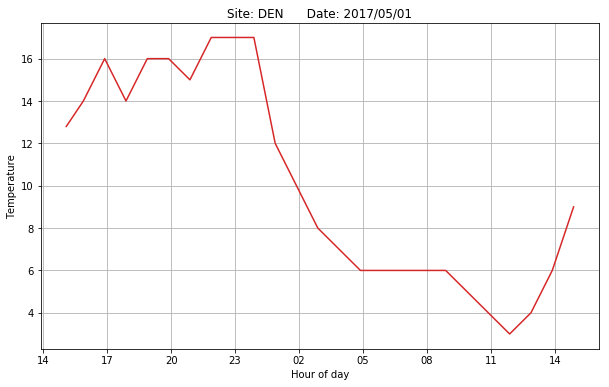

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, AutoDateLocator

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(time, temp_data, color='tab:red')

ax.set_title('Site: {}      Date: {}'.format(station_id, time[0].strftime('%Y/%m/%d')))
ax.set_xlabel('Hour of day')
ax.set_ylabel('Temperature')
ax.grid(True)

# Improve on the default ticking
locator = AutoDateLocator()
hoursFmt = DateFormatter('%H')
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(hoursFmt)

### Exercise 1

# CartoPy

- High level API for dealing with maps
- CartoPy allows you to plot data on a 2D map.
- Support many different map projections
- Support for shapefiles from the GIS world

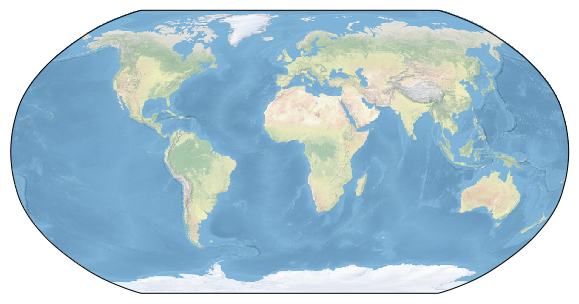

In [19]:
# Importing CartoPy
import cartopy.crs as ccrs

# Works with matplotlib's built-in transform support.
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())

# Sets the extent to cover the whole globe
ax.set_global()

# Adds standard background map
ax.stock_img()

Cartopy also has a lot of built-in support for a variety of map features:

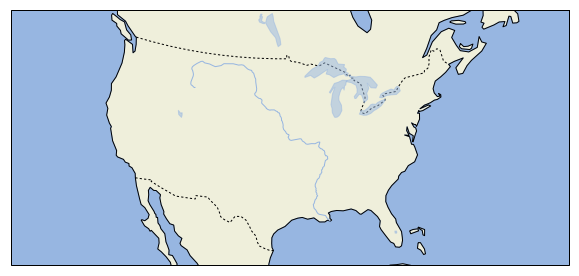

In [20]:
# import cartopy's collection of map features
import cartopy.feature as cfeat

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.LambertConformal())

# Add variety of features
ax.add_feature(cfeat.LAND)
ax.add_feature(cfeat.OCEAN)
ax.add_feature(cfeat.COASTLINE)

# Can also supply matplotlib kwargs
ax.add_feature(cfeat.BORDERS, linestyle=':')
ax.add_feature(cfeat.LAKES, alpha=0.5)
ax.add_feature(cfeat.RIVERS)

# Set limits in lat/lon space
ax.set_extent([-130, -60, 20, 50])

You can also grab other features from the Natural Earth project: http://www.naturalearthdata.com/

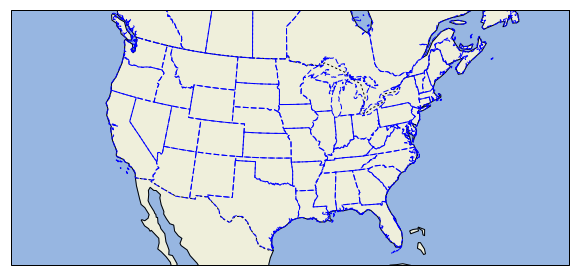

In [21]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.LambertConformal())

ax.add_feature(cfeat.LAND)
ax.add_feature(cfeat.OCEAN)
ax.add_feature(cfeat.COASTLINE)
ax.add_feature(cfeat.BORDERS, linestyle=':')

# Grab state borders
state_borders = cfeat.NaturalEarthFeature(category='cultural',
    name='admin_1_states_provinces_lakes', scale='50m', facecolor='none') 
ax.add_feature(state_borders, linestyle="--", edgecolor='blue')

# Set limits in lat/lon space
ax.set_extent([-130, -60, 20, 50])

## Now, let's request all stations within a bounding box for a given time and create a surface "station plot"
 * Make new NCSS query
 * Request data closest to "now"
 * This time, let's ask for the data in csv format

In [22]:
query = ncss.query()
query.lonlat_box(north=45, south=35, east=-100, west=-110)
query.time(start_time)
query.variables('air_temperature', 'dew_point_temperature', 'inches_ALTIM',
                'wind_speed', 'wind_from_direction', 'cloud_area_fraction')
query.accept('csv')

var=inches_ALTIM&var=wind_from_direction&var=air_temperature&var=dew_point_temperature&var=cloud_area_fraction&var=wind_speed&time=2017-05-01T15%3A00%3A00&west=-110&east=-100&south=35&north=45&accept=csv

## Let's get the data!

In [23]:
from metpy.calc import get_wind_components
from metpy.units import units

data = ncss.get_data(query)

# Access is just like netcdf4-python
lats = data['latitude'][:]
lons = data['longitude'][:]
tair = data['air_temperature'][:]
dewp = data['dew_point_temperature'][:]
slp = (data['inches_ALTIM'][:] * units('inHg')).to('mbar')

# Convert wind to components
u, v = get_wind_components(data['wind_speed'], data['wind_from_direction'] * units.degree)

# Need to handle missing (NaN) and convert to proper code
cloud_cover = 8 * data['cloud_area_fraction']
cloud_cover[np.isnan(cloud_cover)] = 10
cloud_cover = cloud_cover.astype(np.int)

# For some reason these come back as bytes instead of strings
stid = np.array([s.decode() for s in data['station']])

## Create the map using cartopy and MetPy!

### Simple station plotting using plot methods

One way to create station plots with MetPy is to create an instance of `StationPlot` and call various plot methods, like `plot_parameter`, to plot arrays of data at locations relative to the center point.

In addition to plotting values, `StationPlot` has support for plotting text strings, symbols, and plotting values using custom formatting.

Plotting symbols involves mapping integer values to various custom font glyphs in our custom weather symbols font. MetPy provides mappings for converting WMO codes to their appropriate symbol. The `sky_cover` function below is one such mapping.

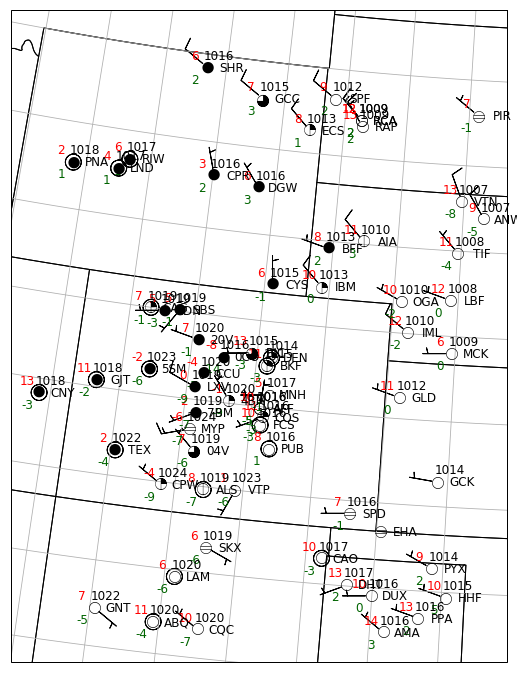

In [24]:
from metpy.plots import StationPlot
from metpy.plots.wx_symbols import sky_cover

# Set up a plot with map features
fig = plt.figure(figsize=(12, 12))
proj = ccrs.Stereographic(central_longitude=-95, central_latitude=35)
ax = fig.add_subplot(1, 1, 1, projection=proj)
ax.add_feature(state_borders, edgecolor='black')
ax.add_feature(cfeat.BORDERS)
ax.coastlines()
ax.gridlines()

# Create a station plot pointing to an Axes to draw on as well as the location of points
stationplot = StationPlot(ax, lons, lats, transform=ccrs.PlateCarree(),
                          fontsize=12)
stationplot.plot_parameter('NW', tair, color='red')
stationplot.plot_parameter('SW', dewp, color='darkgreen')
stationplot.plot_parameter('NE', slp)

# Add wind barbs
stationplot.plot_barb(u, v)

# Plot the sky cover symbols in the center. We give it the integer code values that
# should be plotted, as well as a mapping class that can convert the integer values
# to the appropriate font glyph.
stationplot.plot_symbol('C', cloud_cover, sky_cover)

# Plot station id -- using an offset pair instead of a string location
stationplot.plot_text((2, 0), stid)

Notice how there are so many overlapping stations? There's a utility in MetPy to help with that: `reduce_point_density`. This returns a mask we can apply to data to filter the points.

In [25]:
from metpy.calc import reduce_point_density

# Project points so that we're filtering based on the way the stations are laid out on the map
proj = ccrs.Stereographic(central_longitude=-95, central_latitude=35)
xy = proj.transform_points(ccrs.PlateCarree(), lons, lats)

# Reduce point density so that there's only one point within a 200km circle
mask = reduce_point_density(xy, 200000)

Now we just plot with `arr[mask]` for every `arr` of data we use in plotting.

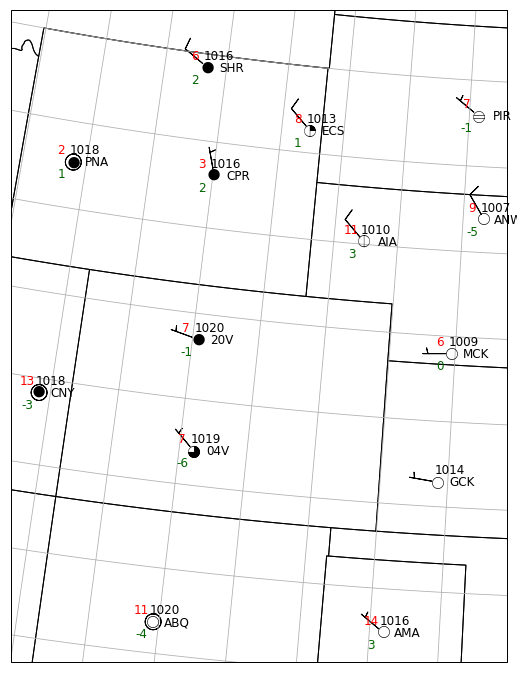

In [26]:
# Set up a plot with map features
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, projection=proj)
ax.add_feature(state_borders, edgecolor='black')
ax.add_feature(cfeat.BORDERS)
ax.coastlines()
ax.gridlines()

# Create a station plot pointing to an Axes to draw on as well as the location of points
stationplot = StationPlot(ax, lons[mask], lats[mask], transform=ccrs.PlateCarree(),
                          fontsize=12)
stationplot.plot_parameter('NW', tair[mask], color='red')
stationplot.plot_parameter('SW', dewp[mask], color='darkgreen')
stationplot.plot_parameter('NE', slp[mask])
stationplot.plot_barb(u[mask], v[mask])
stationplot.plot_symbol('C', cloud_cover[mask], sky_cover)
stationplot.plot_text((2, 0), stid[mask])

More examples for MetPy Station Plots:
- [MetPy Examples](https://unidata.github.io/MetPy/examples/index.html)
- [MetPy Symbol list](https://unidata.github.io/MetPy/api/generated/metpy.plots.StationPlot.html#metpy.plots.StationPlot.plot_symbol)

### Exercise 2